# Combined labels for both cells and nuclei for skin_s2
# Version with late fusion PCA

In [1]:
slide_id = "skin_s2"

In [2]:
import pandas as pd
import scanpy as sc
import spatialdata as sd
import numpy as np
import anndata as ad
from spatialdata.models import get_table_keys
from matplotlib.colors import to_rgba
from functools import partial
from matplotlib import colors

## 1. Load the data

In [3]:
sdata_processed = sd.read_zarr(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_processed/sdata_{slide_id}.zarr", selection=('tables',))
sdata_processed

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'nucleus_boundaries', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


SpatialData object, with associated Zarr store: /Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_processed/sdata_skin_s2.zarr
└── Tables
      ├── 'table_cells': AnnData (87499, 382)
      └── 'table_nuclei': AnnData (87499, 541)
with coordinate systems:

with the following elements in the Zarr store but not in the SpatialData object:
    ▸ st (Points)
    ▸ nucleus_boundaries (Shapes)
    ▸ he (Images)
    ▸ morpho (Images)
    ▸ cell_boundaries (Shapes)

In [4]:
adata_nuclei_ini = sdata_processed.tables['table_nuclei'].copy()
adata_nuclei_ini

AnnData object with n_obs × n_vars = 87499 × 541
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram'
    uns: 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'spatial', 'tangram_pred'

In [5]:
adata_nuclei_ini.var

Empty DataFrame
Columns: []
Index: [ACER1, ACHE, ACTA2, ADAM12, AHNAK2, AHSP, AIF1, AIM2, AKAP5, AKR1C1, ALAS2, ALOX5AP, APCDD1, APOD, AQP1, AQP3, AREG, ARG1, ARHGDIB, ASPN, ATF3, AXL, AZGP1, BASP1, BCAN, BCL2A1, BHLHE41, BIRC3, BIRC5, C11orf96, C15orf48, C1QA, C1orf54, C3, C3AR1, C5AR1, CA1, CALCRL, CALD1, CAPNS2, CBFA2T3, CCL19, CCL2, CCL22, CCL3, CCL4, CCL5, CCL8, CCND1, CCND3, CCR2, CCR7, CD14, CD163, CD1A, CD1B, CD1C, CD207, CD27, CD274, CD276, CD34, CD3D, CD3E, CD3G, CD4, CD40LG, CD52, CD63, CD68, CD69, CD79A, CD83, CD8A, CD93, CDC20, CDH2, CDH5, CDK1, CENPF, CES1, CLDN1, CLDN4, CLDN5, CLEC10A, CLEC9A, COCH, COL17A1, COL5A2, COL6A1, COL6A2, COL6A3, COMP, COTL1, CPE, CPVL, CR2, CRABP2, CRYAB, CSF1R, ...]

[541 rows x 0 columns]

In [6]:
adata_cells_ini = sdata_processed.tables['table_cells'].copy()
adata_cells_ini

AnnData object with n_obs × n_vars = 87499 × 382
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [7]:
adata_cells_ini.var

gene_ids    feature_types   genome
ACER1       ENSG00000167769  Gene Expression  Unknown
ACHE        ENSG00000087085  Gene Expression  Unknown
ACTA2       ENSG00000107796  Gene Expression  Unknown
ADAM12      ENSG00000148848  Gene Expression  Unknown
AHNAK2      ENSG00000185567  Gene Expression  Unknown
...                     ...              ...      ...
VIM         ENSG00000026025  Gene Expression  Unknown
VWF         ENSG00000110799  Gene Expression  Unknown
WDFY4       ENSG00000128815  Gene Expression  Unknown
WIF1        ENSG00000156076  Gene Expression  Unknown
ZNF667-AS1  ENSG00000166770  Gene Expression  Unknown

[382 rows x 3 columns]

## 2. Get adata_nuclei and adata_cyto

In [8]:
adata_cells_ini = adata_cells_ini[adata_cells_ini.obs["transcript_counts"]>10].copy()  # Filter cells with less than 10 transcripts
len(adata_cells_ini.obs)

87455

In [9]:
# Align the cell_id in both AnnData objects
# Create a mapping of cell_id to index position in both objects
nuclei_idx = adata_nuclei_ini.obs.set_index('cell_id').index
cells_idx = adata_cells_ini.obs.set_index('cell_id').index

# Find the intersection of cell_id in both datasets
common_cells = nuclei_idx.intersection(cells_idx)
print(f"Number of common cell_ids: {len(common_cells)}")

# Subset both AnnData objects to include only common cell_ids
adata_nuclei = adata_nuclei_ini[adata_nuclei_ini.obs['cell_id'].isin(common_cells)]
adata_cells = adata_cells_ini[adata_cells_ini.obs['cell_id'].isin(common_cells)]

# Merge the 'obs' dataframes based on 'cell_id' to ensure the same order in both
obs_nuclei = adata_nuclei.obs[['cell_id']].reset_index(drop=True)
obs_cells = adata_cells.obs[['cell_id']].reset_index(drop=True)

# Ensure that both are in the same order
adata_nuclei = adata_nuclei[obs_nuclei['cell_id'].argsort().values]
adata_cells = adata_cells[obs_cells['cell_id'].argsort().values]

# Check that the cell_ids match now
assert np.array_equal(adata_nuclei.obs['cell_id'].values, adata_cells.obs['cell_id'].values), "Cell IDs do not match after alignment."

# Find common genes
common_genes = adata_nuclei.var_names.intersection(adata_cells.var_names)
print(f"Number of common genes: {len(common_genes)}")

# Subset both AnnData objects to include only the common genes
adata_nuclei = adata_nuclei[:, common_genes]
adata_cells = adata_cells[:, common_genes]

# Remove nucleus RNA from cell RNA to get the cytoplasmic RNA
X_cyto = adata_cells.X - adata_nuclei.X

# Because of slight mismatches or rounding, some entries might go negative by 1 or 2 in real data. So we clip to 0:
X_cyto.data = np.clip(X_cyto.data, a_min=0, a_max=None)

# Create a new AnnData object with the cytoplasmic RNA
adata_cyto = ad.AnnData(
    X=X_cyto,
    obs=adata_cells.obs.copy(),  # or adata_nuclei.obs, they should be the same set
    var=adata_cells.var.copy()   # same genes as well
)

Number of common cell_ids: 87455
Number of common genes: 382


In [10]:
adata_nuclei.obs["transcript_counts"] = adata_nuclei.X.sum(axis=1)
adata_nuclei.obs

/var/folders/ff/llzyqd_s78v1k8vywvjxp5_r0000gn/T/ipykernel_35132/547616959.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nuclei.obs["transcript_counts"] = adata_nuclei.X.sum(axis=1)


region   slide     cell_id       area  \
aaaaaaaa-1  nucleus_boundaries  morpho  aaaaaaaa-1  25.106957   
aaaaaaab-1  nucleus_boundaries  morpho  aaaaaaab-1  21.381514   
aaaaaaac-1  nucleus_boundaries  morpho  aaaaaaac-1  12.982376   
aaaaaaad-1  nucleus_boundaries  morpho  aaaaaaad-1   5.983177   
aaaaaaae-1  nucleus_boundaries  morpho  aaaaaaae-1  20.207428   
...                        ...     ...         ...        ...   
aaabffmg-1  nucleus_boundaries  morpho  aaabffmg-1  27.411187   
aaabffmh-1  nucleus_boundaries  morpho  aaabffmh-1  24.044990   
aaabffmi-1  nucleus_boundaries  morpho  aaabffmi-1  13.365703   
aaabffmj-1  nucleus_boundaries  morpho  aaabffmj-1  18.785075   
aaabffmk-1  nucleus_boundaries  morpho  aaabffmk-1  17.407506   

                      ct_tangram  transcript_counts  
aaaaaaaa-1      WISP2 fibroblast                 59  
aaaaaaab-1       COCH fibroblast                 49  
aaaaaaac-1         Myofibroblast                 29  
aaaaaaad-1                Tip EC                 11  
aaaaaaae-1                   Tfh                 49  
...                          ...                ...  
aaabffmg-1  Spinous keratinocyte                114  
aaabffmh-1  Spinous keratinocyte                 94  
aaabffmi-1                  Treg                  8  
aaabffmj-1    C2orf40 fibroblast                 28  
aaabffmk-1    Proliferation T/NK                 40  

[87455 rows x 6 columns]

In [11]:
adata_cyto.obs["transcript_counts"] = adata_cyto.X.sum(axis=1).astype(int)
adata_cyto.obs

cell_id  transcript_counts  control_probe_counts  \
0      aaaaaaaa-1                263                     0   
1      aaaaaaab-1                 86                     0   
2      aaaaaaac-1                 57                     0   
3      aaaaaaad-1                106                     0   
4      aaaaaaae-1                 98                     0   
...           ...                ...                   ...   
87494  aaabffmg-1                117                     0   
87495  aaabffmh-1                 95                     0   
87496  aaabffmi-1                123                     0   
87497  aaabffmj-1                181                     0   
87498  aaabffmk-1                 64                     0   

       control_codeword_counts  unassigned_codeword_counts  \
0                            0                           0   
1                            0                           0   
2                            0                           0   
3                            0                           0   
4                            0                           0   
...                        ...                         ...   
87494                        0                           0   
87495                        0                           0   
87496                        0                           0   
87497                        0                           0   
87498                        0                           1   

       deprecated_codeword_counts  total_counts   cell_area  nucleus_area  \
0                               0           319  222.575164     33.009220   
1                               0           131  108.104066     23.390938   
2                               0            83   64.392815     14.088751   
3                               0           117   88.054691      6.818594   
4                               0           145   94.782972     21.945938   
...                           ...           ...         ...           ...   
87494                           0           217   79.158909     29.712814   
87495                           0           184   61.412502     26.235782   
87496                           0           131  414.805328     14.766094   
87497                           0           208  302.998448     20.320313   
87498                           0           105  136.913755     19.191407   

            region  
0      cell_labels  
1      cell_labels  
2      cell_labels  
3      cell_labels  
4      cell_labels  
...            ...  
87494  cell_labels  
87495  cell_labels  
87496  cell_labels  
87497  cell_labels  
87498  cell_labels  

[87455 rows x 10 columns]

In [12]:
adata_cells_ini.obs

cell_id  transcript_counts  control_probe_counts  \
0      aaaaaaaa-1                319                     0   
1      aaaaaaab-1                131                     0   
2      aaaaaaac-1                 83                     0   
3      aaaaaaad-1                117                     0   
4      aaaaaaae-1                145                     0   
...           ...                ...                   ...   
87494  aaabffmg-1                217                     0   
87495  aaabffmh-1                184                     0   
87496  aaabffmi-1                131                     0   
87497  aaabffmj-1                208                     0   
87498  aaabffmk-1                104                     0   

       control_codeword_counts  unassigned_codeword_counts  \
0                            0                           0   
1                            0                           0   
2                            0                           0   
3                            0                           0   
4                            0                           0   
...                        ...                         ...   
87494                        0                           0   
87495                        0                           0   
87496                        0                           0   
87497                        0                           0   
87498                        0                           1   

       deprecated_codeword_counts  total_counts   cell_area  nucleus_area  \
0                               0           319  222.575164     33.009220   
1                               0           131  108.104066     23.390938   
2                               0            83   64.392815     14.088751   
3                               0           117   88.054691      6.818594   
4                               0           145   94.782972     21.945938   
...                           ...           ...         ...           ...   
87494                           0           217   79.158909     29.712814   
87495                           0           184   61.412502     26.235782   
87496                           0           131  414.805328     14.766094   
87497                           0           208  302.998448     20.320313   
87498                           0           105  136.913755     19.191407   

            region  
0      cell_labels  
1      cell_labels  
2      cell_labels  
3      cell_labels  
4      cell_labels  
...            ...  
87494  cell_labels  
87495  cell_labels  
87496  cell_labels  
87497  cell_labels  
87498  cell_labels  

[87455 rows x 10 columns]

In [13]:
adata_nuclei.var

Empty DataFrame
Columns: []
Index: [ACER1, ACHE, ACTA2, ADAM12, AHNAK2, AHSP, AIF1, AIM2, AKAP5, AKR1C1, ALAS2, ALOX5AP, APCDD1, APOD, AQP1, AQP3, AREG, ARG1, ARHGDIB, ASPN, ATF3, AXL, AZGP1, BASP1, BCAN, BCL2A1, BHLHE41, BIRC3, BIRC5, C11orf96, C15orf48, C1QA, C1orf54, C3, C3AR1, C5AR1, CA1, CALCRL, CALD1, CAPNS2, CBFA2T3, CCL19, CCL2, CCL22, CCL3, CCL4, CCL5, CCL8, CCND1, CCND3, CCR2, CCR7, CD14, CD163, CD1A, CD1B, CD1C, CD207, CD27, CD274, CD276, CD34, CD3D, CD3E, CD3G, CD4, CD40LG, CD52, CD63, CD68, CD69, CD79A, CD83, CD8A, CD93, CDC20, CDH2, CDH5, CDK1, CENPF, CES1, CLDN1, CLDN4, CLDN5, CLEC10A, CLEC9A, COCH, COL17A1, COL5A2, COL6A1, COL6A2, COL6A3, COMP, COTL1, CPE, CPVL, CR2, CRABP2, CRYAB, CSF1R, ...]

[382 rows x 0 columns]

In [14]:
adata_cyto.var

gene_ids    feature_types   genome
ACER1       ENSG00000167769  Gene Expression  Unknown
ACHE        ENSG00000087085  Gene Expression  Unknown
ACTA2       ENSG00000107796  Gene Expression  Unknown
ADAM12      ENSG00000148848  Gene Expression  Unknown
AHNAK2      ENSG00000185567  Gene Expression  Unknown
...                     ...              ...      ...
VIM         ENSG00000026025  Gene Expression  Unknown
VWF         ENSG00000110799  Gene Expression  Unknown
WDFY4       ENSG00000128815  Gene Expression  Unknown
WIF1        ENSG00000156076  Gene Expression  Unknown
ZNF667-AS1  ENSG00000166770  Gene Expression  Unknown

[382 rows x 3 columns]

## 3. Separated PCA

In [15]:
# Preprocess the data

sc.pp.normalize_total(adata_nuclei, target_sum=1e4)
sc.pp.log1p(adata_nuclei)

sc.pp.normalize_total(adata_cyto, target_sum=1e4)
sc.pp.log1p(adata_cyto)

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [16]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata_nuclei, max_value=10)
sc.pp.scale(adata_cyto, max_value=10)

In [17]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata_nuclei, svd_solver="arpack", use_highly_variable=False)
sc.tl.pca(adata_cyto, svd_solver="arpack", use_highly_variable=False)

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


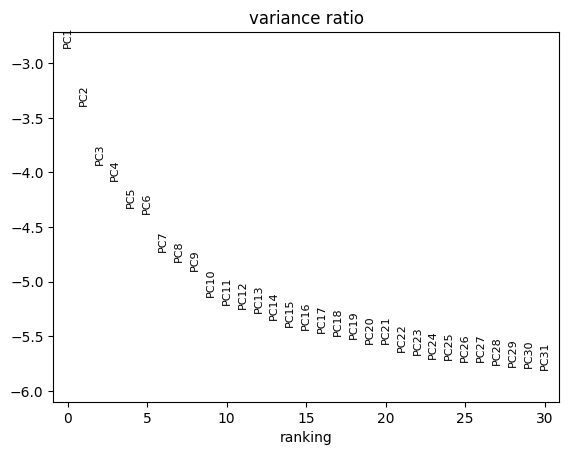

In [18]:
# Contribution of single PCs to the total variance in the data
# This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`
sc.pl.pca_variance_ratio(adata_nuclei, log=True)

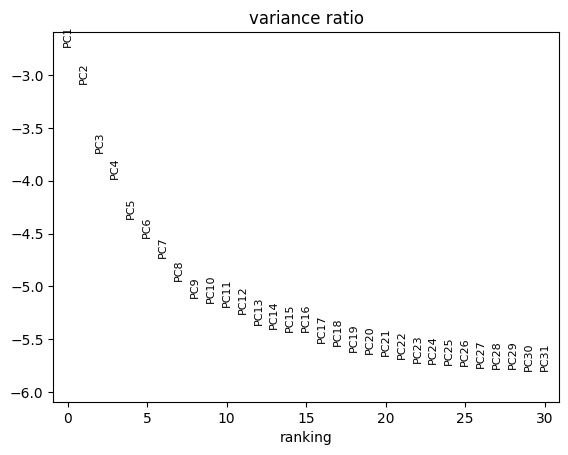

In [19]:
sc.pl.pca_variance_ratio(adata_cyto, log=True)

In [20]:
adata_nuclei

AnnData object with n_obs × n_vars = 87455 × 382
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts'
    var: 'mean', 'std'
    uns: 'sopa_attrs', 'spatialdata_attrs', 'log1p', 'pca'
    obsm: 'spatial', 'tangram_pred', 'X_pca'
    varm: 'PCs'

In [21]:
adata_cyto

AnnData object with n_obs × n_vars = 87455 × 382
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [22]:
# Group the PCs into a single AnnData object
X_nuc_pca = adata_nuclei.obsm["X_pca"][:, :17]
X_cyto_pca = adata_cyto.obsm["X_pca"][:, :17]

# As in MFA, divide the PCs by the square root of the maximal eigenvalue for each dataset separately
X_nuc_pca /= np.sqrt(np.max(adata_nuclei.uns["pca"]["variance"]))
X_cyto_pca /= np.sqrt(np.max(adata_cyto.uns["pca"]["variance"]))

# Check that obs_names align
assert np.array_equal(adata_nuclei.obs['cell_id'].values, adata_cyto.obs['cell_id'].values), "Cell IDs do not match"

# Concatenate along columns (features) and keep only informative PCs
X_combined = np.concatenate([X_nuc_pca, X_cyto_pca], axis=1)

# Create a new AnnData to store these fused PCs
adata_combined = ad.AnnData(X=X_combined, obs=adata_nuclei.obs.copy())

# Name the columns
adata_combined.var_names = [f"PC_nuc_{i}" for i in range(len(X_nuc_pca[0]))] + [f"PC_cyto_{i}" for i in range(len(X_cyto_pca[0]))]

In [23]:
# Check var of first PC for each table is 1
print(np.var(adata_nuclei.obsm["X_pca"][:, 0]))
print(np.var(adata_cyto.obsm["X_pca"][:, 0]))

0.99998856
0.99998873


In [24]:
# Have a look to all the PCs var in the combined data
print("Nuc:")
for i in range(17):
    print(f"PC {i} variance: {np.var(adata_nuclei.obsm['X_pca'][:, i])}")
print("Cyto:")
for i in range(17):
    print(f"PC {i} variance: {np.var(adata_cyto.obsm['X_pca'][:, i])}")

Nuc:
PC 0 variance: 0.9999885559082031
PC 1 variance: 0.5880201458930969
PC 2 variance: 0.34181052446365356
PC 3 variance: 0.296470582485199
PC 4 variance: 0.23023103177547455
PC 5 variance: 0.2195693999528885
PC 6 variance: 0.15475040674209595
PC 7 variance: 0.14070966839790344
PC 8 variance: 0.1298869401216507
PC 9 variance: 0.10253339260816574
PC 10 variance: 0.09538159519433975
PC 11 variance: 0.091410793364048
PC 12 variance: 0.08865167200565338
PC 13 variance: 0.08272503316402435
PC 14 variance: 0.07804200053215027
PC 15 variance: 0.07560719549655914
PC 16 variance: 0.07364629954099655
Cyto:
PC 0 variance: 0.9999887347221375
PC 1 variance: 0.7031782865524292
PC 2 variance: 0.3643733859062195
PC 3 variance: 0.28663814067840576
PC 4 variance: 0.19626310467720032
PC 5 variance: 0.16361887753009796
PC 6 variance: 0.1352340281009674
PC 7 variance: 0.10884980857372284
PC 8 variance: 0.09302715957164764
PC 9 variance: 0.08810960501432419
PC 10 variance: 0.08506426960229874
PC 11 varianc

In [25]:
# Add final labels coming from table nuclei and table cells

sdata_final = sd.read_zarr(f"/Volumes/DD_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_{slide_id}.zarr", selection=('tables', 'shapes'))

cellid2transcript_cat = dict(sdata_final.tables['table_cells'].obs[['cell_id', 'transcript_cat']].values)

cellid2nucleilabel = dict(sdata_final.tables['table_nuclei'].obs[['cell_id', 'final_label']].values)
cellid2celllabel = dict(sdata_final.tables['table_cells'].obs[['cell_id', 'final_label']].values)

cellid2nucleilabel1 = dict(sdata_final.tables['table_nuclei'].obs[['cell_id', 'label1']].values)
cellid2celllabel1 = dict(sdata_final.tables['table_cells'].obs[['cell_id', 'label1']].values)

adata_combined.obs['transcript_cat'] = adata_combined.obs['cell_id'].map(cellid2transcript_cat).fillna('Unknown')

adata_combined.obs['final_label_nuclei'] = adata_combined.obs['cell_id'].map(cellid2nucleilabel).fillna('Unknown')
adata_combined.obs['final_label_cells'] = adata_combined.obs['cell_id'].map(cellid2celllabel).fillna('Unknown')

adata_combined.obs['label1_nuclei'] = adata_combined.obs['cell_id'].map(cellid2nucleilabel1).fillna('Unknown')
adata_combined.obs['label1_cells'] = adata_combined.obs['cell_id'].map(cellid2celllabel1).fillna('Unknown')

adata_combined.obs

region   slide     cell_id       area  \
aaaaaaaa-1  nucleus_boundaries  morpho  aaaaaaaa-1  25.106957   
aaaaaaab-1  nucleus_boundaries  morpho  aaaaaaab-1  21.381514   
aaaaaaac-1  nucleus_boundaries  morpho  aaaaaaac-1  12.982376   
aaaaaaad-1  nucleus_boundaries  morpho  aaaaaaad-1   5.983177   
aaaaaaae-1  nucleus_boundaries  morpho  aaaaaaae-1  20.207428   
...                        ...     ...         ...        ...   
aaabffmg-1  nucleus_boundaries  morpho  aaabffmg-1  27.411187   
aaabffmh-1  nucleus_boundaries  morpho  aaabffmh-1  24.044990   
aaabffmi-1  nucleus_boundaries  morpho  aaabffmi-1  13.365703   
aaabffmj-1  nucleus_boundaries  morpho  aaabffmj-1  18.785075   
aaabffmk-1  nucleus_boundaries  morpho  aaabffmk-1  17.407506   

                      ct_tangram  transcript_counts  transcript_cat  \
aaaaaaaa-1      WISP2 fibroblast                 59               6   
aaaaaaab-1       COCH fibroblast                 49               3   
aaaaaaac-1         Myofibroblast                 29               2   
aaaaaaad-1                Tip EC                 11               3   
aaaaaaae-1                   Tfh                 49               4   
...                          ...                ...             ...   
aaabffmg-1  Spinous keratinocyte                114               5   
aaabffmh-1  Spinous keratinocyte                 94               4   
aaabffmi-1                  Treg                  8               3   
aaabffmj-1    C2orf40 fibroblast                 28               5   
aaabffmk-1    Proliferation T/NK                 40               2   

                  final_label_nuclei         final_label_cells label1_nuclei  \
aaaaaaaa-1  Fibroblast_Myofibroblast                   Myeloid    Fibroblast   
aaaaaaab-1                      T_NK                      T_NK             T   
aaaaaaac-1                      T_NK                      T_NK             T   
aaaaaaad-1                      T_NK                      T_NK             T   
aaaaaaae-1                      T_NK                      T_NK          T/NK   
...                              ...                       ...           ...   
aaabffmg-1                Epithelial                Epithelial    Epithelial   
aaabffmh-1                Epithelial                Epithelial    Epithelial   
aaabffmi-1                    Less10  Fibroblast_Myofibroblast        less10   
aaabffmj-1                      T_NK  Fibroblast_Myofibroblast             T   
aaabffmk-1                Epithelial                Epithelial    Epithelial   

                   label1_cells  
aaaaaaaa-1  Monocyte/Macrophage  
aaaaaaab-1                    T  
aaaaaaac-1                    T  
aaaaaaad-1                    T  
aaaaaaae-1                    T  
...                         ...  
aaabffmg-1           Epithelial  
aaabffmh-1           Epithelial  
aaabffmi-1           Fibroblast  
aaabffmj-1           Fibroblast  
aaabffmk-1           Epithelial  

[87455 rows x 11 columns]

In [26]:
adata_combined

AnnData object with n_obs × n_vars = 87455 × 34
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts', 'transcript_cat', 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells'

In [27]:
adata_combined.var

Empty DataFrame
Columns: []
Index: [PC_nuc_0, PC_nuc_1, PC_nuc_2, PC_nuc_3, PC_nuc_4, PC_nuc_5, PC_nuc_6, PC_nuc_7, PC_nuc_8, PC_nuc_9, PC_nuc_10, PC_nuc_11, PC_nuc_12, PC_nuc_13, PC_nuc_14, PC_nuc_15, PC_nuc_16, PC_cyto_0, PC_cyto_1, PC_cyto_2, PC_cyto_3, PC_cyto_4, PC_cyto_5, PC_cyto_6, PC_cyto_7, PC_cyto_8, PC_cyto_9, PC_cyto_10, PC_cyto_11, PC_cyto_12, PC_cyto_13, PC_cyto_14, PC_cyto_15, PC_cyto_16]

## 4. PCA on the two separated PCA (late fusion) + Clustering

In [28]:
# Run a "second PCA" on the scaled features
# No scaling because we already scaled using the maximum eigenvalue for each table
sc.tl.pca(adata_combined)

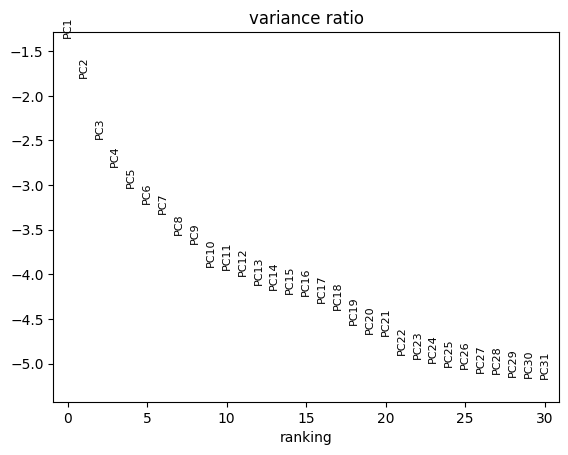

In [29]:
sc.pl.pca_variance_ratio(adata_combined, log=True)

In [30]:
adata_combined

AnnData object with n_obs × n_vars = 87455 × 34
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts', 'transcript_cat', 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [31]:
# Neighborhood graph of cells using the PCA representation of the data matrix
sc.pp.neighbors(adata_combined, n_neighbors=10, n_pcs=23, use_rep="X_pca", key_added='pca_n10_pcs23')
# Embedding the neighborhood graph using UMAP
sc.tl.umap(adata_combined, neighbors_key='pca_n10_pcs23')
# Leiden clustering directly clusters the neighborhood graph of cells
sc.tl.leiden(adata_combined, resolution=0.4, random_state=0, n_iterations=2, directed=False, key_added='pca_n10_pcs23_leiden_res0.4', neighbors_key='pca_n10_pcs23')
sc.tl.leiden(adata_combined, resolution=0.6, random_state=0, n_iterations=2, directed=False, key_added='pca_n10_pcs23_leiden_res0.6', neighbors_key='pca_n10_pcs23')

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/ff/llzyqd_s78v1k8vywvjxp5_r0000gn/T/ipykernel_35132/1482264999.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined, resolution=0.4, random_state=0, n_iterations=2, directed=False, key_added='pca_n10_pcs23_leiden_res0.4', neighbors_key='pca_n10_pcs23')


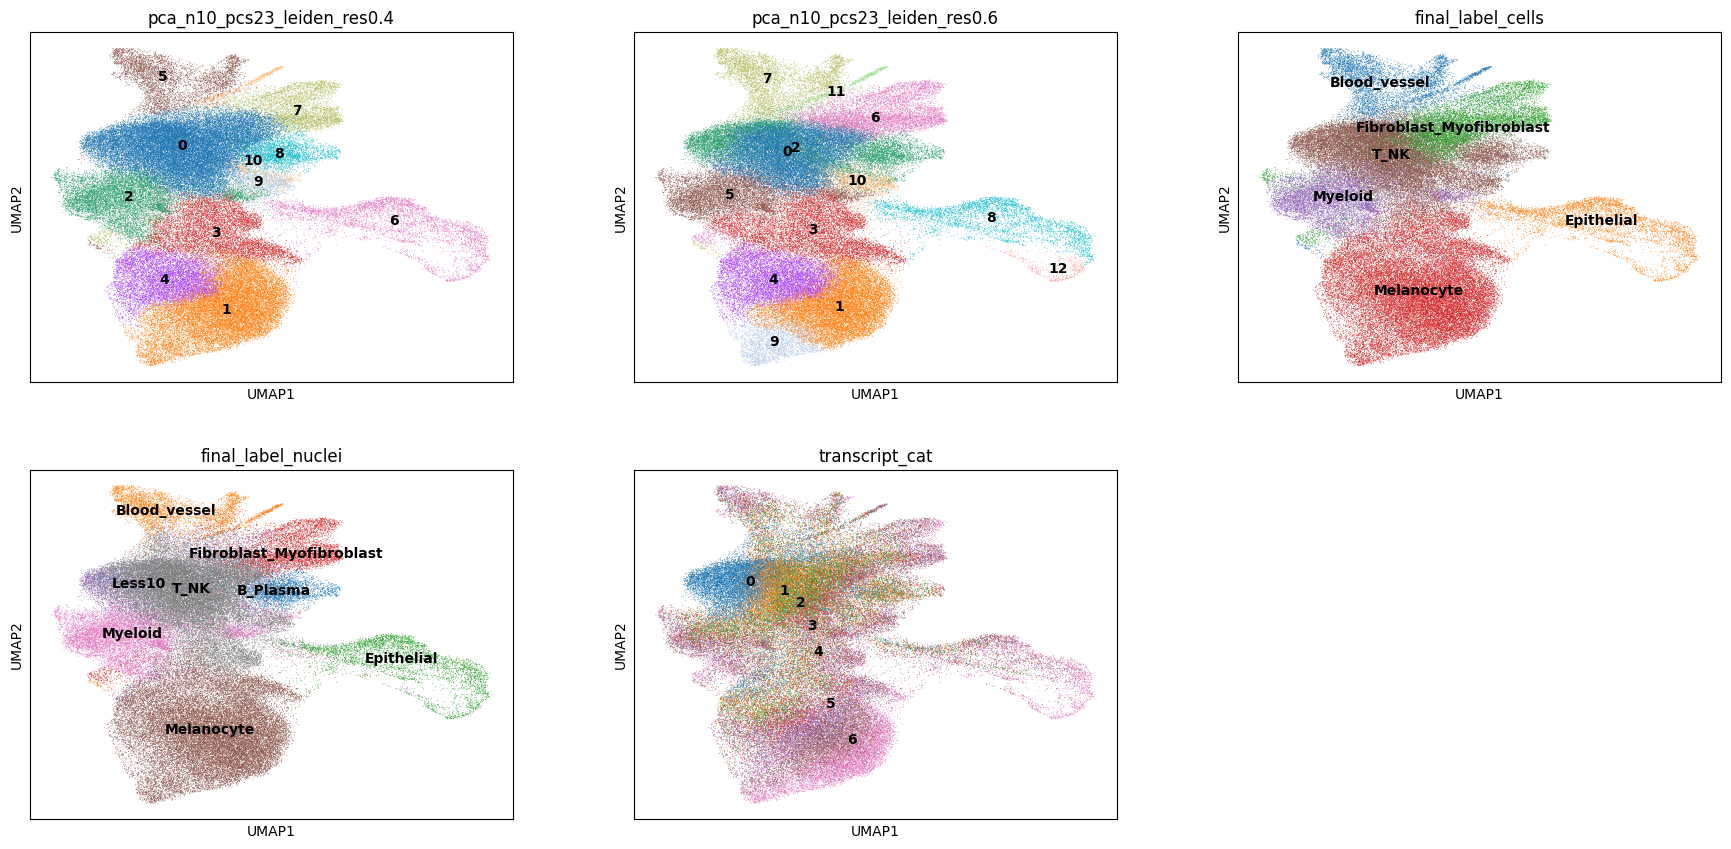

In [32]:
# Plot the clusters
adata_combined.obs['transcript_cat'] = pd.Categorical(adata_combined.obs['transcript_cat'])
sc.pl.umap(adata_combined, neighbors_key='pca_n10_pcs23',
           color=['pca_n10_pcs23_leiden_res0.4', 'pca_n10_pcs23_leiden_res0.6', 'final_label_cells', 'final_label_nuclei', 'transcript_cat'],
           ncols=3, legend_loc='on data')

In [33]:
clustering_label = 'pca_n10_pcs23_leiden_res0.4'

In [34]:
# Put the clustering_label into the adata_cells to be able to use marker genes, and also final_label_cells and final_label_nuclei
cellid2clustering_label = dict(adata_combined.obs[['cell_id', clustering_label]].values)
adata_cells.obs["cluster_combined"] = adata_cells.obs['cell_id'].map(cellid2clustering_label).fillna('Unknown')
adata_cells.obs["final_label_cells"] = adata_cells.obs['cell_id'].map(cellid2celllabel).fillna('Unknown')
adata_cells.obs["final_label_nuclei"] = adata_cells.obs['cell_id'].map(cellid2nucleilabel).fillna('Unknown')


# Preprocess the adata_cells
sc.pp.normalize_total(adata_cells, target_sum=1e4)
sc.pp.log1p(adata_cells)

# Add X_umap to adata_cells, checking before cell_id alignment
assert np.array_equal(adata_cells.obs['cell_id'].values, adata_combined.obs['cell_id'].values), "Cell IDs do not match"
adata_cells.obsm['X_umap'] = adata_combined.obsm['X_umap']

# Wilcoxon rank-sum (Mann-Whitney-U) test. 
# You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.
sc.tl.rank_genes_groups(adata_cells, "cluster_combined", method="wilcoxon", corr_method="benjamini-hochberg", key_added="rank_genes_"+"cluster_combined")
# The top ranked genes per cluster
top_ranked_genes = pd.DataFrame(adata_cells.uns["rank_genes_"+"cluster_combined"]["names"]).iloc[:7, :]
list_genes = pd.concat([top_ranked_genes[col] for col in top_ranked_genes], ignore_index=True).tolist()

/var/folders/ff/llzyqd_s78v1k8vywvjxp5_r0000gn/T/ipykernel_35132/4236311698.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cells.obs["cluster_combined"] = adata_cells.obs['cell_id'].map(cellid2clustering_label).fillna('Unknown')


## 5. Analyze and get combined labels

### Helper functions

In [35]:
def analyze_clusters(adata, resolution_key):
    
    # Ensure the resolution key exists in obs
    if resolution_key not in adata.obs:
        raise ValueError(f"{resolution_key} not found in adata.obs.")
    
    # Group data by the specified clustering resolution
    cluster_groups = adata.obs.groupby(resolution_key)

    results = {}

    for cluster_id, group in cluster_groups:
        
        # Calculate dominant labels for final_label_cells
        label_cells_counts = group['final_label_cells'].value_counts(normalize=True)
        dominant_cells = label_cells_counts.head(2) * 100  # Get top 2 labels as percentages

        # Calculate top1 for label1 for cells
        label1_cells_counts = group['label1_cells'].value_counts(normalize=True)
        top1_cells = label1_cells_counts.head(1) * 100

        # Calculate dominant labels for final_label_nuclei
        label_nuclei_counts = group['final_label_nuclei'].value_counts(normalize=True)
        dominant_nuclei = label_nuclei_counts.head(2) * 100  # Get top 2 labels as percentages

        # Calculate top1 for label1 for nuclei
        label1_nuclei_counts = group['label1_nuclei'].value_counts(normalize=True)
        top1_nuclei = label1_nuclei_counts.head(1) * 100
        if top1_nuclei.keys()[0] == 'less_10_rna':
            top1_nuclei = label1_nuclei_counts.head(2).tail(1) * 100
        
        # Align categories for comparison
        common_categories = group['final_label_cells'].cat.categories.union(group['final_label_nuclei'].cat.categories)
        group['final_label_cells'] = group['final_label_cells'].cat.set_categories(common_categories)
        group['final_label_nuclei'] = group['final_label_nuclei'].cat.set_categories(common_categories)

        # Count different labels between final_label_cells and final_label_nuclei
        total_cells = len(group)  # Total number of cells in the cluster
        differing_labels_count_woUnknown = ((group['final_label_cells'] != group['final_label_nuclei']) & (group['final_label_nuclei'] != 'Unknown')  & (group['final_label_nuclei'] != 'Less10')).sum() / total_cells * 100
        differing_labels_count = (group['final_label_cells'] != group['final_label_nuclei']).sum() / total_cells * 100

        # Store the results
        results[cluster_id] = (dominant_cells.to_dict(), dominant_nuclei.to_dict(), top1_cells.to_dict(), top1_nuclei.to_dict(), differing_labels_count_woUnknown, differing_labels_count)

    return results

In [36]:
def analyze_cluster_dominance(cluster_analysis_results):
    
    clusters_unknown_cells = []
    clusters_different_top1 = []
    clusters_high_diff = []

    for cluster_id, (dominant_cells, dominant_nuclei, label1_cells, label1_nuclei, diff_percentage_woUnknown, _) in cluster_analysis_results.items():
        
        # Check if top 1 dominant_cells is 'Unknown' or 'Less10'
        
        top1_dominant_cells = max(dominant_cells, key=dominant_cells.get)
        if top1_dominant_cells == 'Unknown' or top1_dominant_cells == 'Less10':
            clusters_unknown_cells.append(cluster_id)
        
        # Check if top 1 for dominant_cells is different from dominant_nuclei
        
        top1_dominant_nuclei = max(dominant_nuclei, key=dominant_nuclei.get)

        if top1_dominant_nuclei == 'Unknown' or top1_dominant_nuclei == 'Less10':
            sorted_nuclei = sorted(dominant_nuclei.items(), key=lambda x: x[1], reverse=True)
            if len(sorted_nuclei) > 1:  # Make sure there's a second element
                top1_dominant_nuclei = sorted_nuclei[1][0]

        if top1_dominant_cells != top1_dominant_nuclei:
            clusters_different_top1.append(cluster_id)
        
        # Check if diff_percentage_woUnknown is greater than 40%
        
        if diff_percentage_woUnknown > 40:
            clusters_high_diff.append(cluster_id)

    print(f"Clusters where the top 1 for dominant_cells is 'Unknown' or 'Less10': {clusters_unknown_cells}")
    print(f"Clusters where the top 1 for dominant_cells differs from dominant_nuclei (excluding 'Unknown' and 'Less10'): {clusters_different_top1}")
    print(f"Clusters where diff_percentage_woUnknown is greater than 40%: {clusters_high_diff}")

    print("=" * 50)

    clusters_to_analyse = set(clusters_unknown_cells + clusters_different_top1 + clusters_high_diff)
    for cluster_id in clusters_to_analyse:
        print(f"\nCluster ID: {cluster_id}")
        print(f"Dominant final_label_cells: {cluster_analysis_results[cluster_id][0]} - with dominant label1: {cluster_analysis_results[cluster_id][2]}")
        print(f"Dominant final_label_nuclei: {cluster_analysis_results[cluster_id][1]} - with dominant label1: {cluster_analysis_results[cluster_id][3]}")
        print(f"Count of differing labels without 'Unknown' or 'Less10' label for Nuclei: {round(cluster_analysis_results[cluster_id][4], 2)} %")
        print(f"Count of differing labels: {round(cluster_analysis_results[cluster_id][5], 2)} %")
        print(f"% of cells in cluster: {round(len(adata_combined.obs[adata_combined.obs[clustering_label] == cluster_id]) / len(adata_combined.obs) * 100, 2)} %")
        print("-----")

In [37]:
def assign_final_labels(cluster_analysis_results, input_dict):
    
    dict_combined_labels = {}

    for cluster_id, (dominant_cells, _, _, _, _, _) in cluster_analysis_results.items():
        
        if cluster_id in input_dict:
            # Use the label from input_dict if cluster_id is in it
            dict_combined_labels[cluster_id] = input_dict[cluster_id]
        else:
            # Otherwise, use the dominant label from final_label_cells
            dict_combined_labels[cluster_id] = max(dominant_cells, key=dominant_cells.get)

    return dict_combined_labels

### Analysis

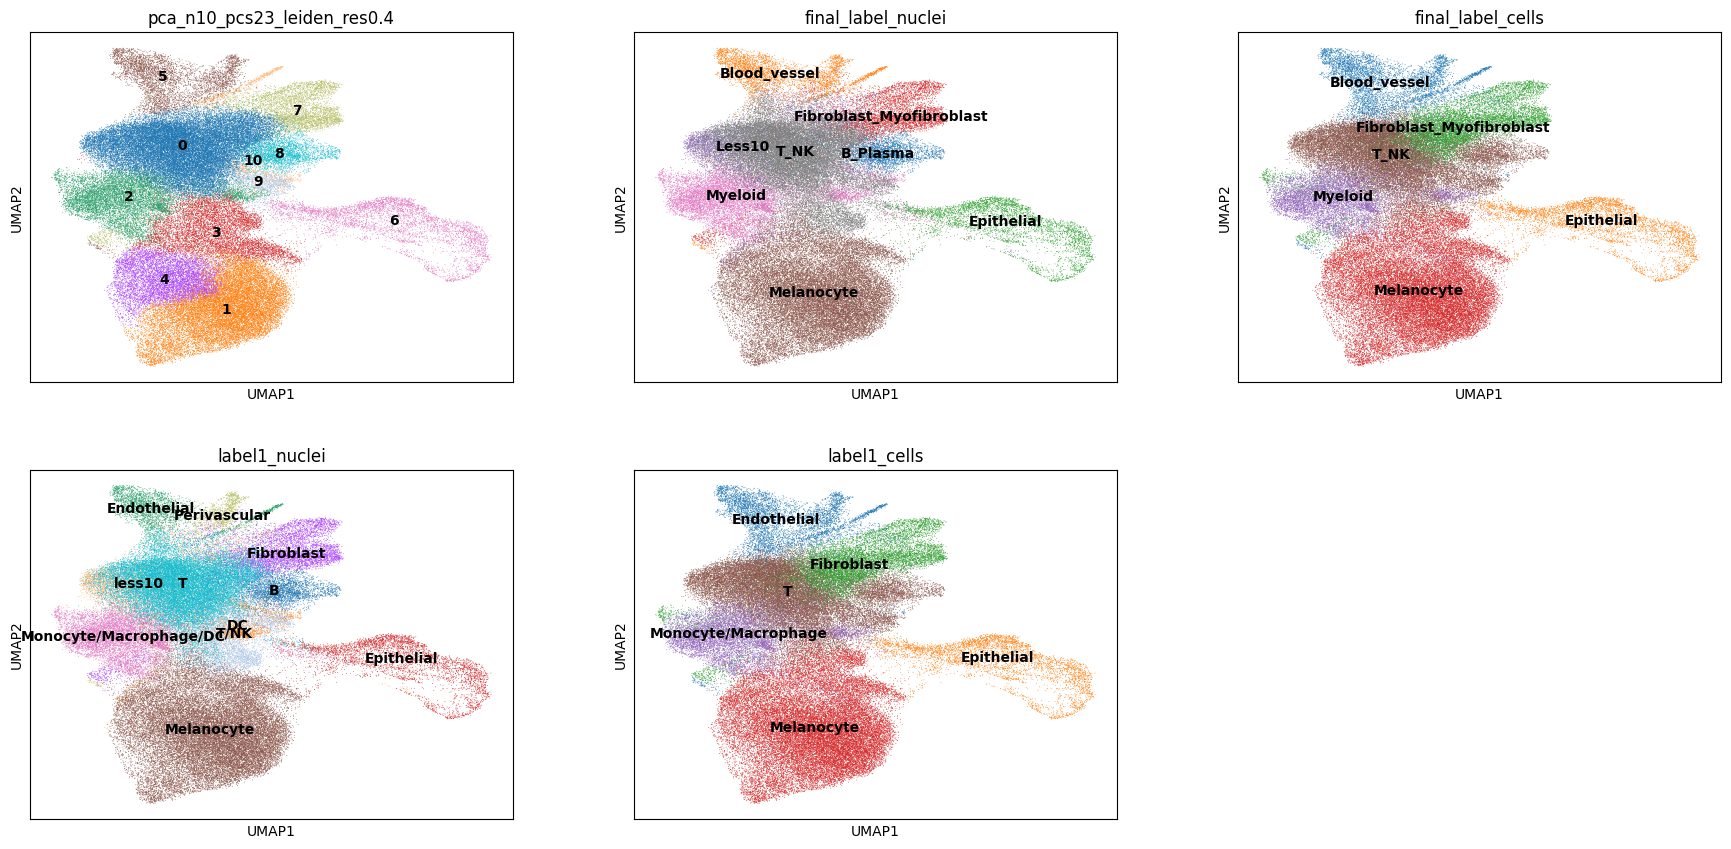

In [38]:
# Plot the clusters
sc.pl.umap(adata_combined, neighbors_key='pca_n10_pcs23',
           color=[clustering_label, 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells'],
           ncols=3, legend_loc='on data')

In [39]:
cluster_analysis_results = analyze_clusters(adata_combined, clustering_label)

for cluster_id, (dominant_cells, dominant_nuclei, _, _, diff_count_woUnknown, diff_count) in cluster_analysis_results.items():
    print("=" * 50)
    print(f"Cluster ID: {cluster_id}")
    print(f"Dominant final_label_cells: {dominant_cells}")
    print(f"Dominant final_label_nuclei: {dominant_nuclei}")
    print(f"Count of differing labels without 'Unknown/Less10' label for Nuclei: {round(diff_count_woUnknown, 2)} %")
    print(f"Count of differing labels: {round(diff_count, 2)} %\n")

Cluster ID: 0
Dominant final_label_cells: {'T_NK': 70.77338786241145, 'Fibroblast_Myofibroblast': 22.792667786460235}
Dominant final_label_nuclei: {'T_NK': 82.57138683999123, 'Less10': 8.332724749872197}
Count of differing labels without 'Unknown/Less10' label for Nuclei: 26.76 %
Count of differing labels: 35.09 %

Cluster ID: 1
Dominant final_label_cells: {'Melanocyte': 99.0, 'Myeloid': 0.6763005780346821}
Dominant final_label_nuclei: {'Melanocyte': 99.757225433526, 'T_NK': 0.12716763005780346}
Count of differing labels without 'Unknown/Less10' label for Nuclei: 1.14 %
Count of differing labels: 1.14 %

Cluster ID: 2
Dominant final_label_cells: {'Myeloid': 83.64035087719299, 'T_NK': 7.182017543859649}
Dominant final_label_nuclei: {'Myeloid': 87.94956140350877, 'T_NK': 4.901315789473684}
Count of differing labels without 'Unknown/Less10' label for Nuclei: 19.85 %
Count of differing labels: 22.75 %

Cluster ID: 3
Dominant final_label_cells: {'Melanocyte': 72.59867977906507, 'T_NK': 21.0

/var/folders/ff/llzyqd_s78v1k8vywvjxp5_r0000gn/T/ipykernel_35132/1125182952.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_groups = adata.obs.groupby(resolution_key)


In [40]:
analyze_cluster_dominance(cluster_analysis_results)

Clusters where the top 1 for dominant_cells is 'Unknown' or 'Less10': []
Clusters where the top 1 for dominant_cells differs from dominant_nuclei (excluding 'Unknown' and 'Less10'): ['8', '10']
Clusters where diff_percentage_woUnknown is greater than 40%: ['8', '10']

Cluster ID: 10
Dominant final_label_cells: {'Blood_vessel': 48.661417322834644, 'T_NK': 47.40157480314961} - with dominant label1: {'Endothelial': 48.661417322834644}
Dominant final_label_nuclei: {'Myeloid': 40.23622047244094, 'Blood_vessel': 30.236220472440944} - with dominant label1: {'DC': 39.60629921259842}
Count of differing labels without 'Unknown' or 'Less10' label for Nuclei: 54.09 %
Count of differing labels: 56.69 %
% of cells in cluster: 1.45 %
-----

Cluster ID: 8
Dominant final_label_cells: {'T_NK': 91.31121642969984, 'Fibroblast_Myofibroblast': 4.802527646129541} - with dominant label1: {'T': 91.31121642969984}
Dominant final_label_nuclei: {'B_Plasma': 90.99526066350711, 'T_NK': 5.529225908372828} - with dom

0      MS4A1
1      CD79A
2      WDFY4
3       IRF8
4      PTGDS
5         C3
6    ARHGDIB
Name: 8, dtype: object


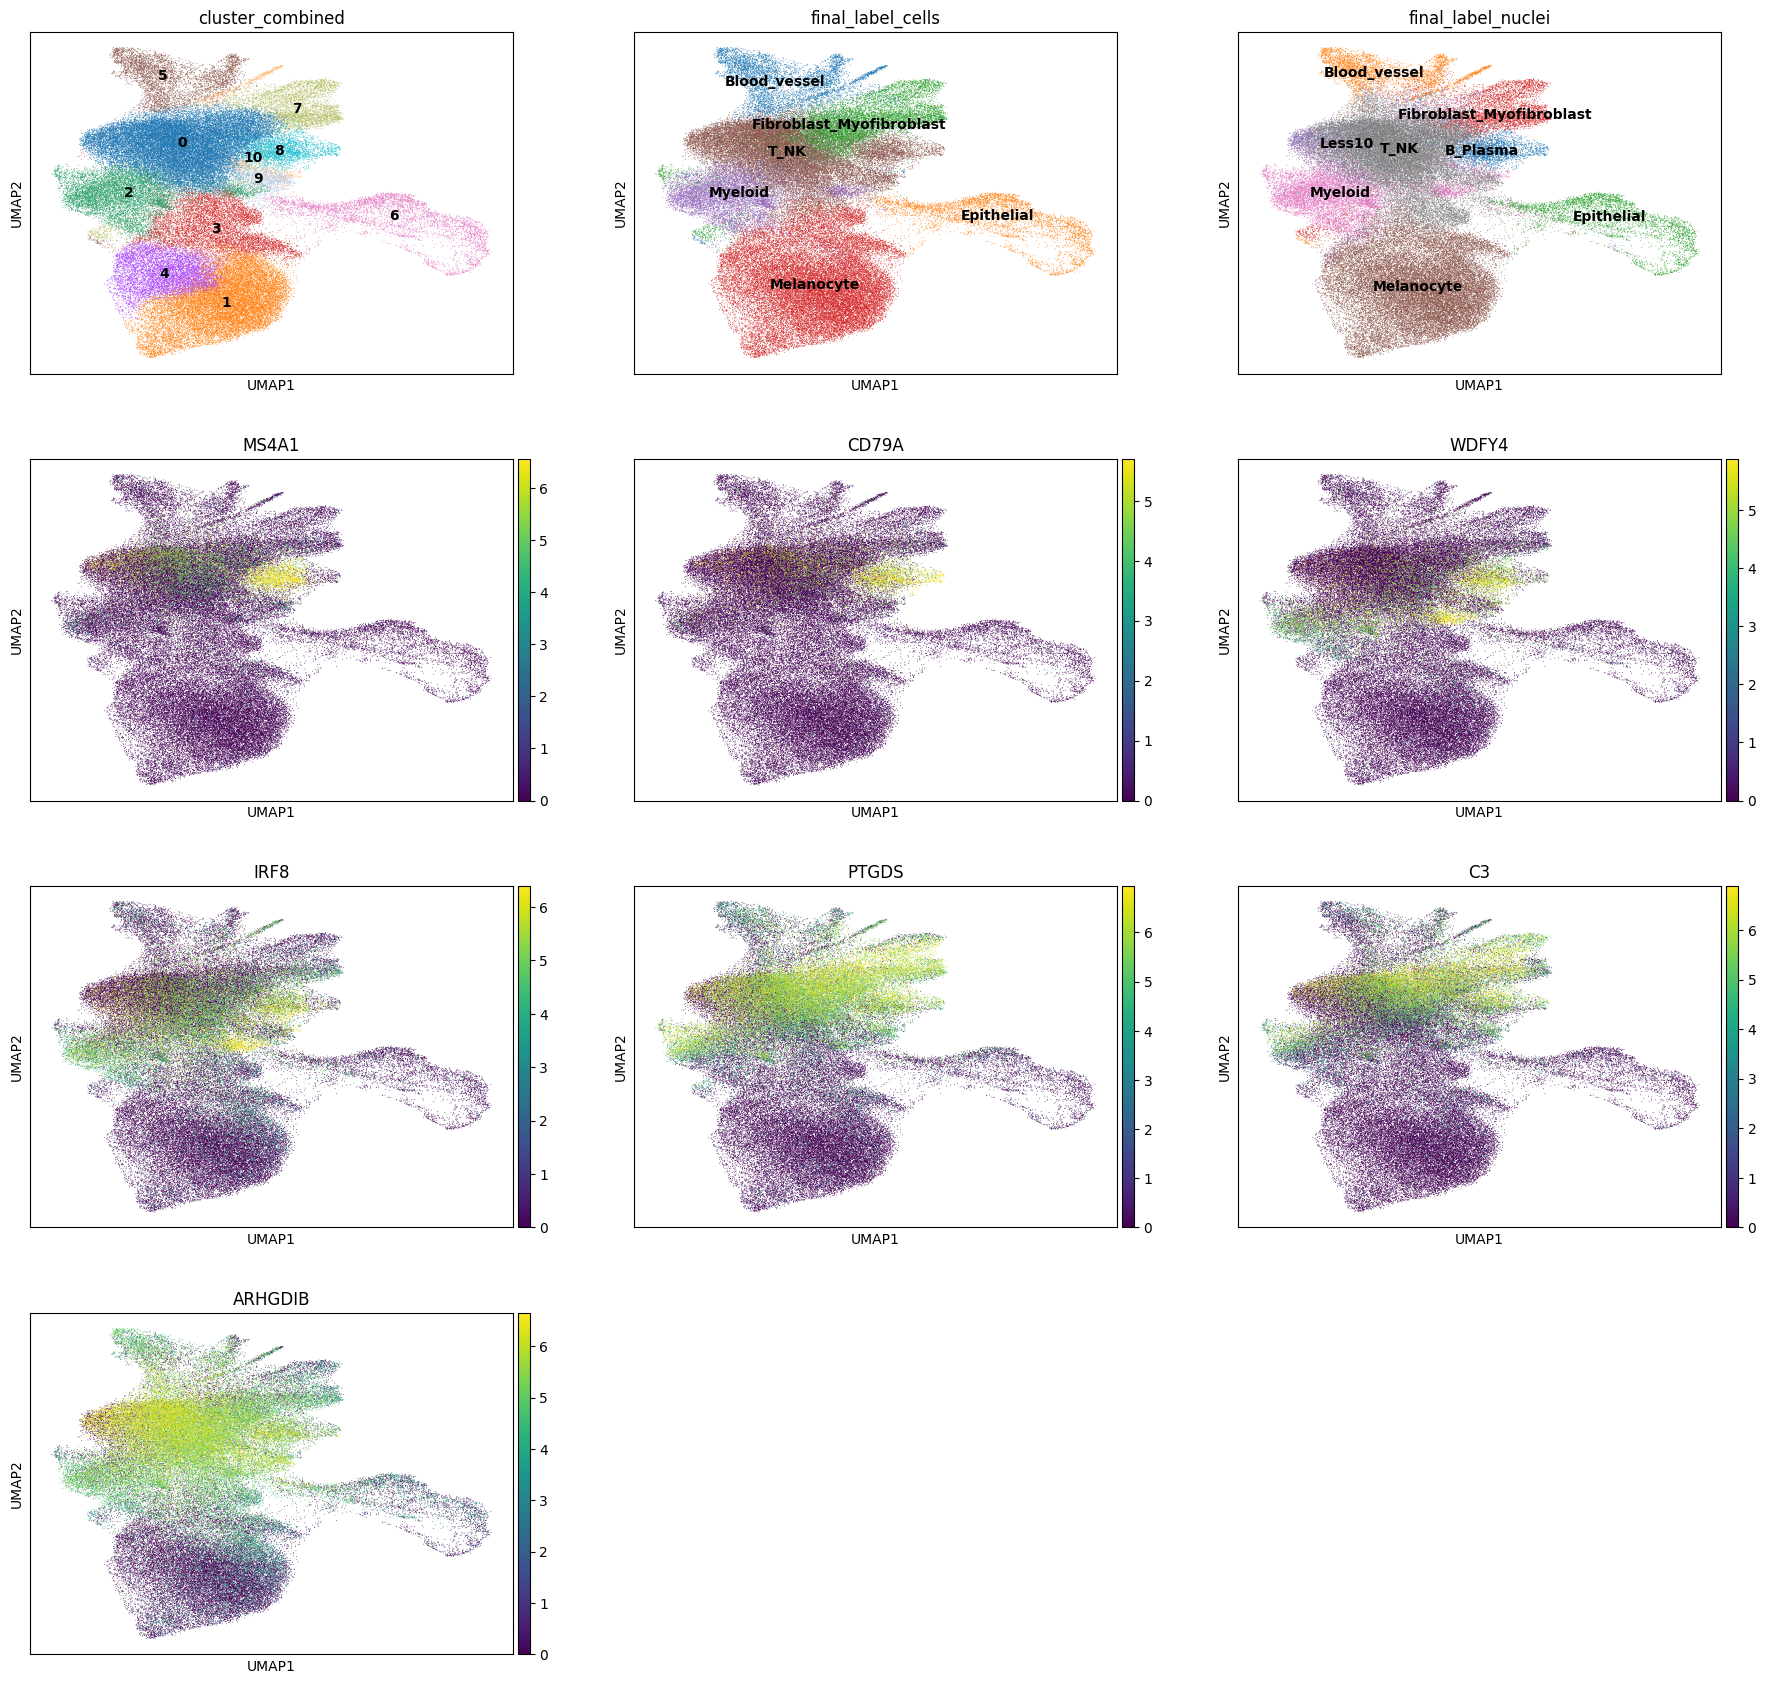

In [41]:
cluster_id = '8'
print(top_ranked_genes[cluster_id])
sc.pl.umap(adata_cells, color=["cluster_combined", 'final_label_cells', 'final_label_nuclei']+list_genes[int(cluster_id)*7:int(cluster_id)*7+7], vmax="p99", vmin=0, ncols=3, legend_loc='on data')

0    FSCN1
1    BIRC3
2     CCR7
3     CD83
4    MMRN1
5    BASP1
6      FN1
Name: 10, dtype: object


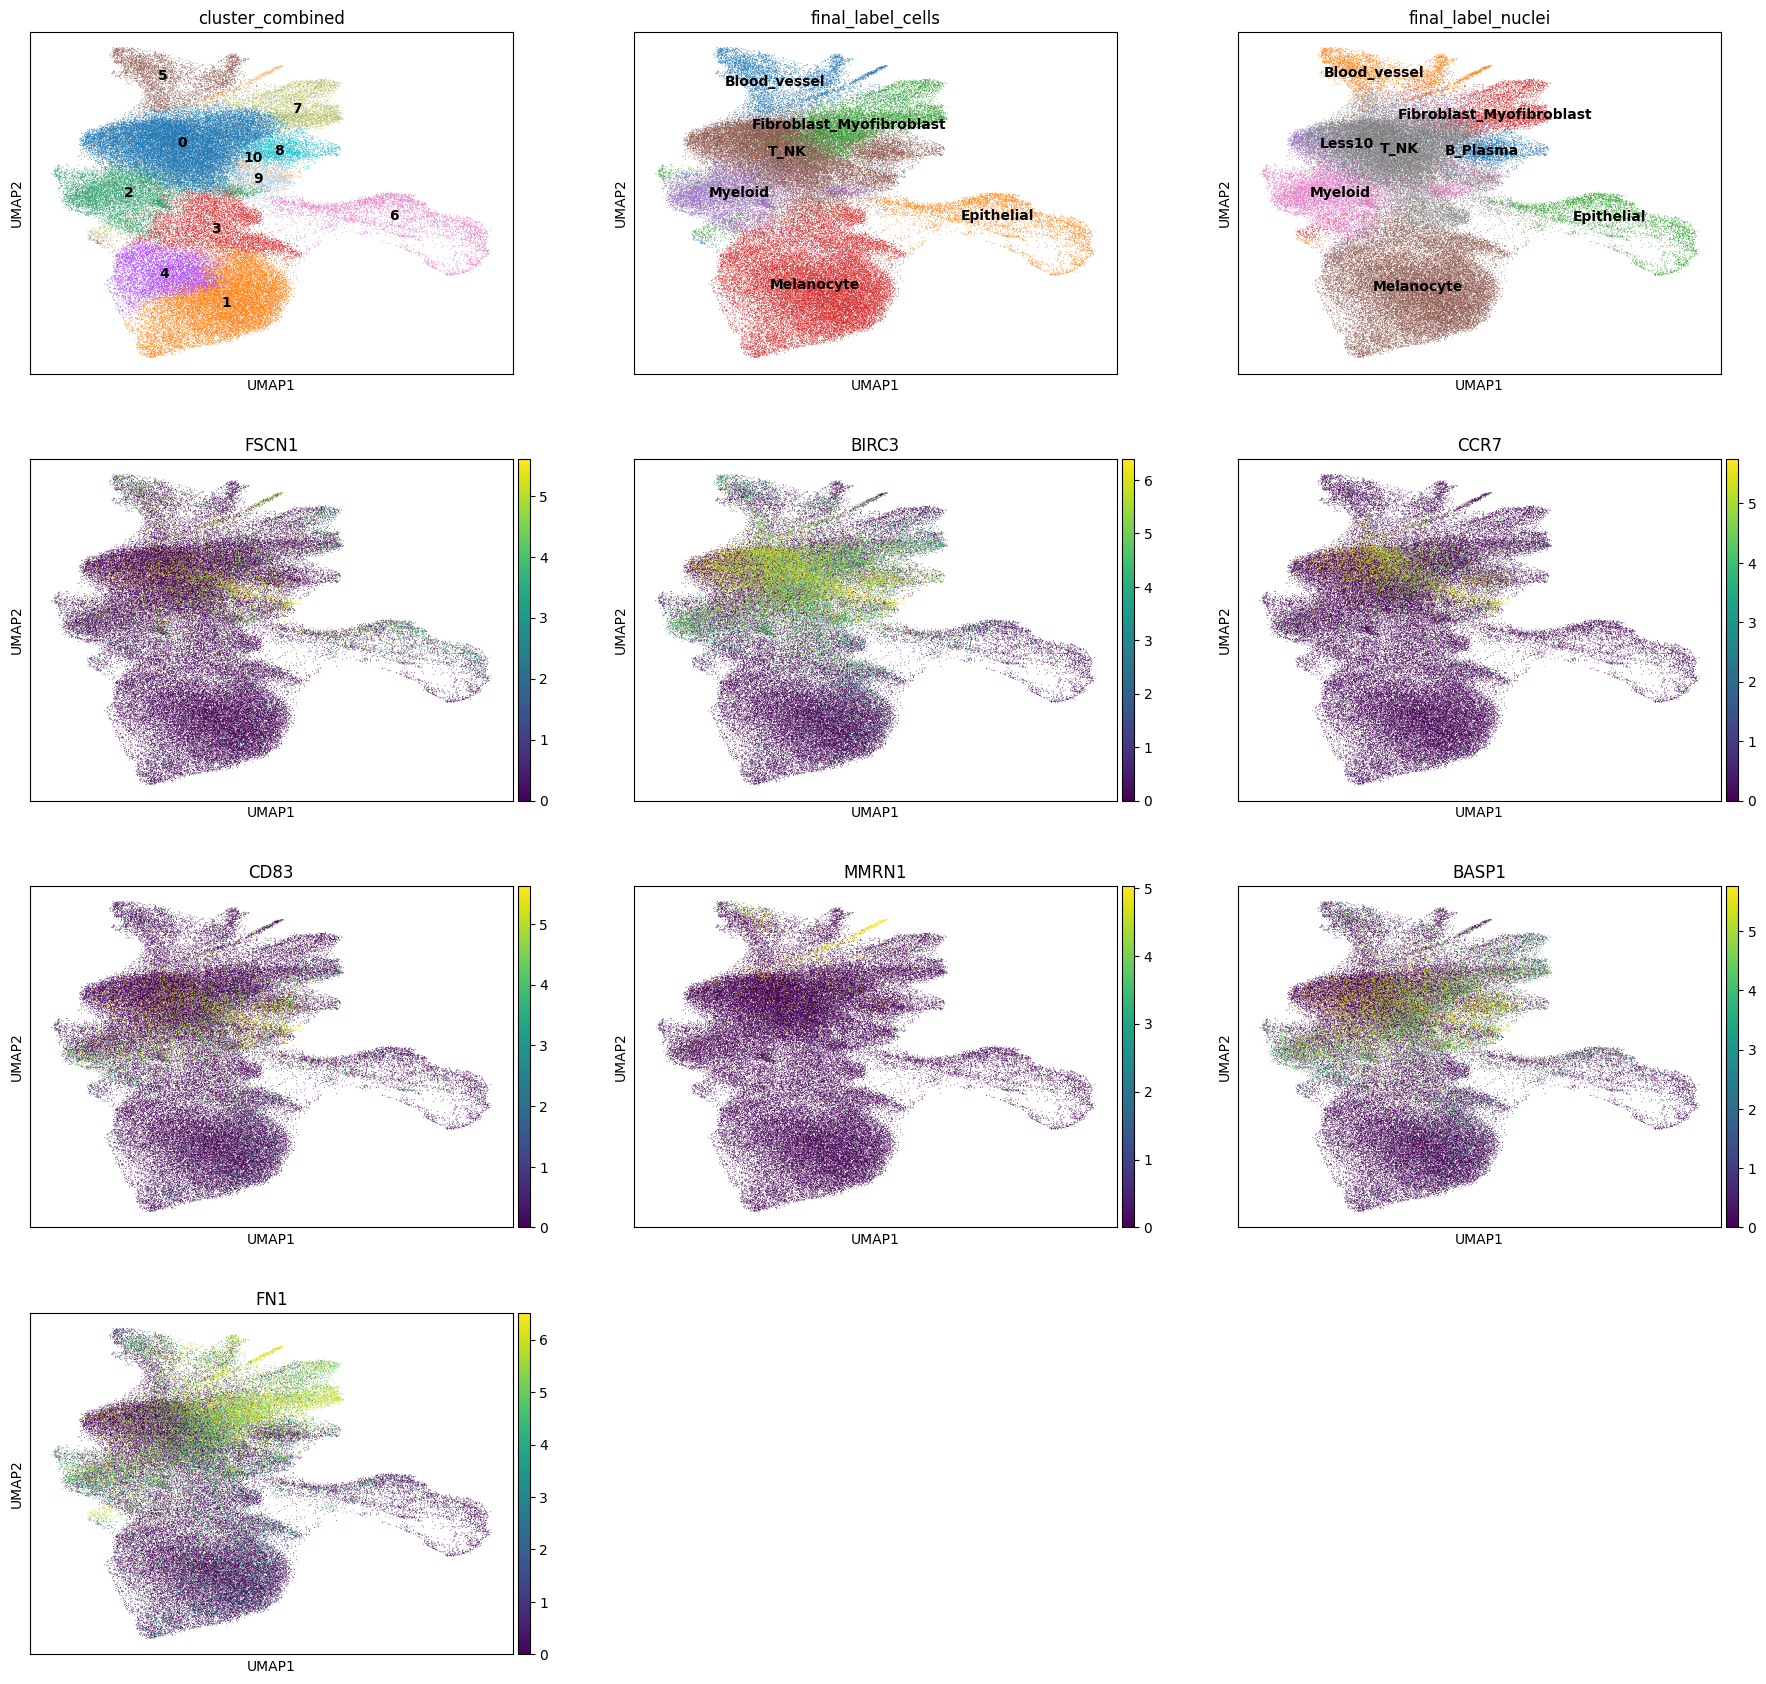

In [42]:
cluster_id = '10'
print(top_ranked_genes[cluster_id])
sc.pl.umap(adata_cells, color=["cluster_combined", 'final_label_cells', 'final_label_nuclei']+list_genes[int(cluster_id)*7:int(cluster_id)*7+7], vmax="p99", vmin=0, ncols=3, legend_loc='on data')

In [43]:
dict_combined_labels = assign_final_labels(cluster_analysis_results, {'8':'B_Plasma'})
dict_combined_labels

{'0': 'T_NK',
 '1': 'Melanocyte',
 '2': 'Myeloid',
 '3': 'Melanocyte',
 '4': 'Melanocyte',
 '5': 'Blood_vessel',
 '6': 'Epithelial',
 '7': 'Fibroblast_Myofibroblast',
 '8': 'B_Plasma',
 '9': 'T_NK',
 '10': 'Blood_vessel'}

In [44]:
adata_combined.obs['final_label_combined'] = adata_combined.obs[clustering_label].map(dict_combined_labels)
adata_combined.obs

region   slide     cell_id       area  \
aaaaaaaa-1  nucleus_boundaries  morpho  aaaaaaaa-1  25.106957   
aaaaaaab-1  nucleus_boundaries  morpho  aaaaaaab-1  21.381514   
aaaaaaac-1  nucleus_boundaries  morpho  aaaaaaac-1  12.982376   
aaaaaaad-1  nucleus_boundaries  morpho  aaaaaaad-1   5.983177   
aaaaaaae-1  nucleus_boundaries  morpho  aaaaaaae-1  20.207428   
...                        ...     ...         ...        ...   
aaabffmg-1  nucleus_boundaries  morpho  aaabffmg-1  27.411187   
aaabffmh-1  nucleus_boundaries  morpho  aaabffmh-1  24.044990   
aaabffmi-1  nucleus_boundaries  morpho  aaabffmi-1  13.365703   
aaabffmj-1  nucleus_boundaries  morpho  aaabffmj-1  18.785075   
aaabffmk-1  nucleus_boundaries  morpho  aaabffmk-1  17.407506   

                      ct_tangram  transcript_counts transcript_cat  \
aaaaaaaa-1      WISP2 fibroblast                 59              6   
aaaaaaab-1       COCH fibroblast                 49              3   
aaaaaaac-1         Myofibroblast                 29              2   
aaaaaaad-1                Tip EC                 11              3   
aaaaaaae-1                   Tfh                 49              4   
...                          ...                ...            ...   
aaabffmg-1  Spinous keratinocyte                114              5   
aaabffmh-1  Spinous keratinocyte                 94              4   
aaabffmi-1                  Treg                  8              3   
aaabffmj-1    C2orf40 fibroblast                 28              5   
aaabffmk-1    Proliferation T/NK                 40              2   

                  final_label_nuclei         final_label_cells label1_nuclei  \
aaaaaaaa-1  Fibroblast_Myofibroblast                   Myeloid    Fibroblast   
aaaaaaab-1                      T_NK                      T_NK             T   
aaaaaaac-1                      T_NK                      T_NK             T   
aaaaaaad-1                      T_NK                      T_NK             T   
aaaaaaae-1                      T_NK                      T_NK          T/NK   
...                              ...                       ...           ...   
aaabffmg-1                Epithelial                Epithelial    Epithelial   
aaabffmh-1                Epithelial                Epithelial    Epithelial   
aaabffmi-1                    Less10  Fibroblast_Myofibroblast        less10   
aaabffmj-1                      T_NK  Fibroblast_Myofibroblast             T   
aaabffmk-1                Epithelial                Epithelial    Epithelial   

                   label1_cells pca_n10_pcs23_leiden_res0.4  \
aaaaaaaa-1  Monocyte/Macrophage                           7   
aaaaaaab-1                    T                           0   
aaaaaaac-1                    T                           0   
aaaaaaad-1                    T                           0   
aaaaaaae-1                    T                           0   
...                         ...                         ...   
aaabffmg-1           Epithelial                           6   
aaabffmh-1           Epithelial                           6   
aaabffmi-1           Fibroblast                           7   
aaabffmj-1           Fibroblast                           0   
aaabffmk-1           Epithelial                           6   

           pca_n10_pcs23_leiden_res0.6      final_label_combined  
aaaaaaaa-1                           6  Fibroblast_Myofibroblast  
aaaaaaab-1                           0                      T_NK  
aaaaaaac-1                           0                      T_NK  
aaaaaaad-1                           0                      T_NK  
aaaaaaae-1                           0                      T_NK  
...                                ...                       ...  
aaabffmg-1                           8                Epithelial  
aaabffmh-1                           8                Epithelial  
aaabffmi-1                           6  Fibroblast_Myofibroblast  
aaabffmj-1    

In [45]:
adata_combined.obs['final_label_combined'].value_counts(dropna=False)

final_label_combined
Melanocyte                  31634
T_NK                        28891
Myeloid                      9120
Blood_vessel                 5876
Epithelial                   4520
Fibroblast_Myofibroblast     4249
B_Plasma                     3165
Name: count, dtype: int64

In [46]:
# Create final table, adding cell_id with less than 10 transcripts

adata_combined_missing = adata_nuclei_ini[~adata_nuclei_ini.obs_names.isin(adata_combined.obs_names)].copy()
adata_combined_missing.obs['final_label_combined'] = 'Less10'
adata_combined_missing.obs['final_label_nuclei'] = 'Less10'
adata_combined_missing.obs['final_label_cells'] = 'Less10'
print(adata_combined.shape[0] + adata_combined_missing.shape[0])

adata_combined_all = ad.concat([adata_combined, adata_combined_missing], join="outer", merge="first", uns_merge="first", pairwise=True)
print(adata_combined_all.shape[0])

87499
87499


In [47]:
adata_combined_all

AnnData object with n_obs × n_vars = 87499 × 575
    obs: 'region', 'slide', 'cell_id', 'area', 'ct_tangram', 'transcript_counts', 'transcript_cat', 'final_label_nuclei', 'final_label_cells', 'label1_nuclei', 'label1_cells', 'pca_n10_pcs23_leiden_res0.4', 'pca_n10_pcs23_leiden_res0.6', 'final_label_combined'
    uns: 'pca', 'pca_n10_pcs23', 'umap', 'pca_n10_pcs23_leiden_res0.4', 'pca_n10_pcs23_leiden_res0.6', 'pca_n10_pcs23_leiden_res0.4_colors', 'pca_n10_pcs23_leiden_res0.6_colors', 'final_label_cells_colors', 'final_label_nuclei_colors', 'transcript_cat_colors', 'label1_nuclei_colors', 'label1_cells_colors', 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'X_pca', 'X_umap', 'spatial', 'tangram_pred'
    varm: 'PCs'
    obsp: 'pca_n10_pcs23_distances', 'pca_n10_pcs23_connectivities'

In [48]:
adata_combined_all.obs['final_label_combined'].value_counts(dropna=False)

final_label_combined
Melanocyte                  31634
T_NK                        28891
Myeloid                      9120
Blood_vessel                 5876
Epithelial                   4520
Fibroblast_Myofibroblast     4249
B_Plasma                     3165
Less10                         44
Name: count, dtype: int64

In [49]:
# Add in sdata final
sdata_final.tables['table_combined'] = adata_combined_all

In [50]:
# Convert in str the final_label_combined, final_label_cells and final_label_nuclei to see it in Napari
sdata_final.tables['table_combined'].obs['final_label_combined'] = sdata_final.tables['table_combined'].obs['final_label_combined'].astype(str)
sdata_final.tables['table_combined'].obs['final_label_cells'] = sdata_final.tables['table_combined'].obs['final_label_cells'].astype(str)
sdata_final.tables['table_combined'].obs['final_label_nuclei'] = sdata_final.tables['table_combined'].obs['final_label_nuclei'].astype(str)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


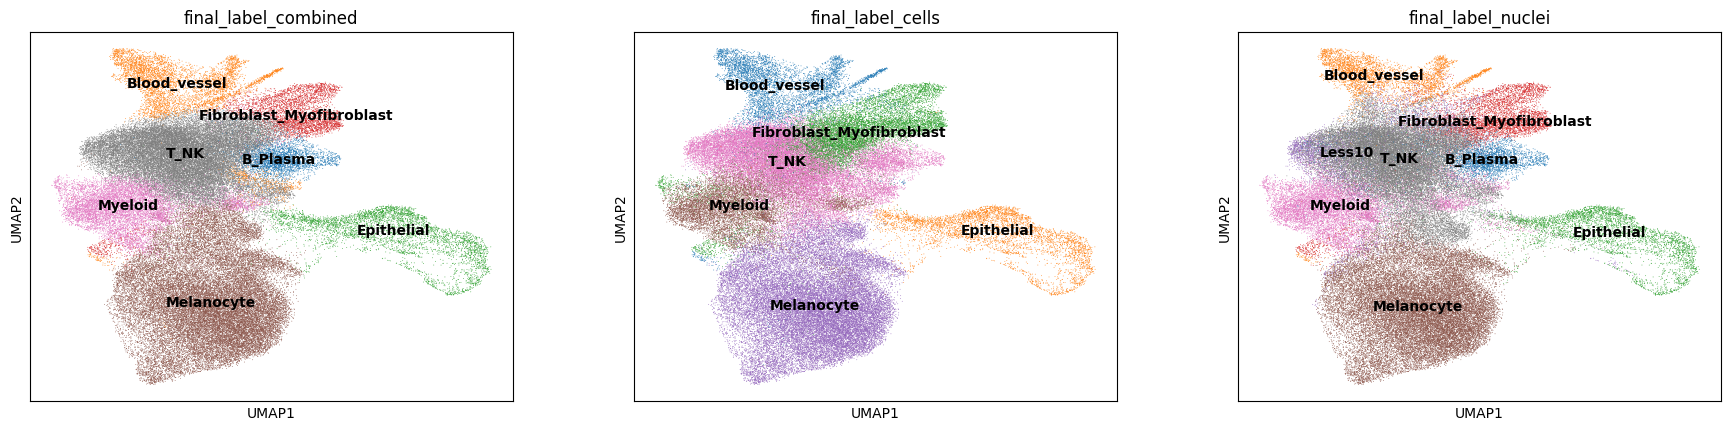

In [51]:
sc.pl.umap(sdata_final.tables['table_combined'], color=['final_label_combined', 'final_label_cells', 'final_label_nuclei'], ncols=3, legend_loc='on data')

In [52]:
# Put table_combined as annotating cell_boundaries

sdata_final["table_combined"].obs["region"] = "cell_boundaries"
sdata_final.tables["table_combined"].obs['region'] = sdata_final.tables["table_combined"].obs['region'].astype('category')
sdata_final.set_table_annotates_spatialelement(table_name="table_combined", region="cell_boundaries", region_key="region", instance_key="cell_id")

region, region_key, instance_key = get_table_keys(sdata_final["table_combined"])
print(region, region_key, instance_key)

cell_boundaries region cell_id


In [53]:
# Color for final label in Napari

to_hex = partial(colors.to_hex, keep_alpha=True)

# Normalize the RGB values to the range [0, 1] by dividing by 255
napari_color = {
                "T_NK": to_hex(to_rgba([255/255, 15/255, 15/255])[:3]),                      # Red
                "B_Plasma": to_hex(to_rgba([255/255, 143/255, 15/255])[:3]),                 # Orange
                "Myeloid": to_hex(to_rgba([255/255, 211/255, 15/255])[:3]),                  # Yellow
                "Blood_vessel": to_hex(to_rgba([70/255, 128/255, 0/255])[:3]),               # Dark Green
                "Fibroblast_Myofibroblast": to_hex(to_rgba([156/255, 255/255, 36/255])[:3]), # Light Green
                "Epithelial": to_hex(to_rgba([57/255, 208/255, 133/255])[:3]),               # Blue Green
                "Specialized": to_hex(to_rgba([69/255, 237/255, 255/255])[:3]),              # Turquoise
                "Melanocyte": to_hex(to_rgba([22/255, 169/255, 223/255])[:3]),               # Blue
                "Stem_like": to_hex(to_rgba([22/255, 69/255, 223/255])[:3]),                 # Dark Blue
                "Glioblastoma": to_hex(to_rgba([130/255, 55/255, 235/255])[:3]),             # Purple
                "Unknown": to_hex(to_rgba([0/255, 0/255, 0/255])[:3]),                       # Black
                "Less10": to_hex(to_rgba([143/255, 143/255, 143/255])[:3])                   # Grey
                }

sdata_final.tables['table_combined'].uns["final_label_combined_colors"] = napari_color
sdata_final.tables['table_combined'].uns["final_label_cells_colors"] = napari_color
sdata_final.tables['table_combined'].uns["final_label_nuclei_colors"] = napari_color

In [54]:
sdata_final.write_element("table_combined")